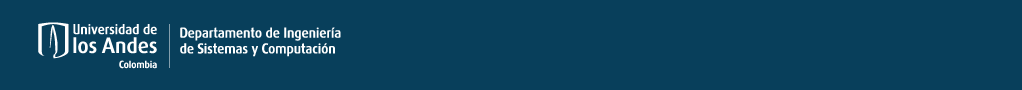

# Ciencia de datos aplicada
-------------------------------

# Grupo 09 - Entrega 2

**TODO: Por favor revisen los códigos**

## Integrantes:

1. Geovanny Andrés González - 201719528
2. Andrés Felipe Vega Chacón - 201910197
3. Wilson Camilo Sánchez - 201910197

## Objetivos

- Proponer a una organización, una idea o problema a abordar desde la ciencia de datos.
- Proponer un modelo predictivo inicial para la organización que de una solución al
problema.

## Preparación del entorno

A continuación, vamos a descargar las librerias necesarias para la ejecución del ejercicio. De igual modo, vamos a descargar el dataset de trabajo.

Por favor le recomendamos ejecutar este notebook desde **Google Colab** debido a que vamos a trabajar con diversas librerias complicadas de instalar como Tensorflow y Tensorboard. 

### Descarga de librerias

In [ ]:
%%capture
!pip install -U scikit-learn
!pip install plotly
!pip install pandas-profiling==3.1.0
!pip install xgboost
!pip install tensorflow-addons

### Descargar datos

Puede acceder a la URL original del *dataset* haciendo clic en el siguiente enlace. Debido a que vamos a trabajar con **Google Colab**, Kaggle no permite descargar el dataset directamente, por lo que lo vamos a replicar en un bucket de **Amazon S3**

**Dataset en Kaggle**: [Dataset](https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility)

In [ ]:
# Crear la carpeta con los datos
DATA_PATH = "/content/data"
!mkdir -p $DATA_PATH

In [ ]:
# Descargar los datos
DATA_URL = "https://ggonzr-public-data.s3.amazonaws.com/cda/heart.csv"
!wget --directory-prefix $DATA_PATH/ $DATA_URL

### Importar librerías

In [17]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas_profiling as pp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from typing import List

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, roc_auc_score

In [ ]:
# Validar que Tensorflow esté disponible en el entorno
try:
  %tensorflow_version 2.x
except:
  print("Por favor ejecute el notebook en Google Colab")

### Cargar datos

A continuación, vamos a realizar la carga inicial de los datos

In [18]:
##df = pd.read_csv(filepath_or_buffer=f"{DATA_PATH}/heart.csv")
df = pd.read_csv("heart.csv")
df.head(4)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1

In [19]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

## Enfoque analítico

**TODO: Terminar la sección**

## Entendimiento y preparación de los datos

A continuación, vamos a realizar un análisis exploratorio sobre la calidad del conjunto de datos.

In [20]:
pd_prof = pp.ProfileReport(df, title="Información cardiovascular")

In [21]:
# Mostrar el reporte
pd_prof

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

A continuación, vamos a realizar una depuración al conjunto de datos para eliminar los valores faltantes y los duplicados.

**TODO: Por favor no olviden transformar las variables categoricas y depurar el dataset. Realicen las transformaciones que consideren necesarias**

**Por favor que la variable del dataset depurado tenga como nombre: df. Lo anterior, para que cuadre con el resto del ejercicio**

In [22]:
print("Tamaño de los datos antes de la depuración: " + str(df.shape) + "\n")

df = df.dropna()
df = df.drop_duplicates()

print("Tamaño de los datos despues de la depuración: " + str(df.shape) + "\n")
print("Cambio de tipo de dato:\n" + str(df.dtypes))

Tamaño de los datos antes de la depuración: (303, 14)

Tamaño de los datos despues de la depuración: (302, 14)

Cambio de tipo de dato:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


## Preparación de los datos

En esta sección, vamos a separar el conjunto de datos en entrenamiento, validación y test

In [23]:
# Selección de las variables de entrenamiento
y_data = df["target"]
x_data = df.drop(columns="target")

# Separar el conjunto de test: 20%
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=5)

# Separar el conjunto de validación: 20%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=6)

#### Validación de la distribución

Para corroborar que la distribución de los datos sea similiar, vamos a realizar un histograma y en él vamos a graficar la distribución de los datos.

In [24]:
def graph_var(x_train: np.array, x_val: np.array, x_test: np.array, vars: List[str]):
  """
  Permite graficar la distribución de una variable
  para cada uno de los subconjuntos de datos

  x_train: np.array
    Subconjunto de entrenamiento
  x_val: np.array
    Subconjunto de validación
  x_test: np.array
    Subconjunto de pruebas
  vars: List[str]
    Variables a graficar. Deben pertenecer a los 3 subconjuntos  
  """

  # Crear la nueva figura
  fig, ax = plt.subplots(nrows=len(vars), ncols=3, figsize=(30, 100))

  # Graficar las 3 distribuciones
  for var_idx in range(len(vars)):
    var_name = vars[var_idx]
    sns.histplot(data=x_train, x=var_name, kde=True, ax=ax[var_idx, 0]).set(title=f"Distribución de {var_name} en x_train")
    sns.histplot(data=x_val, x=var_name, kde=True, ax=ax[var_idx, 1]).set(title=f"Distribución de {var_name} en x_val")
    sns.histplot(data=x_test, x=var_name, kde=True, ax=ax[var_idx, 2]).set(title=f"Distribución de {var_name} en x_test")

  return fig, ax

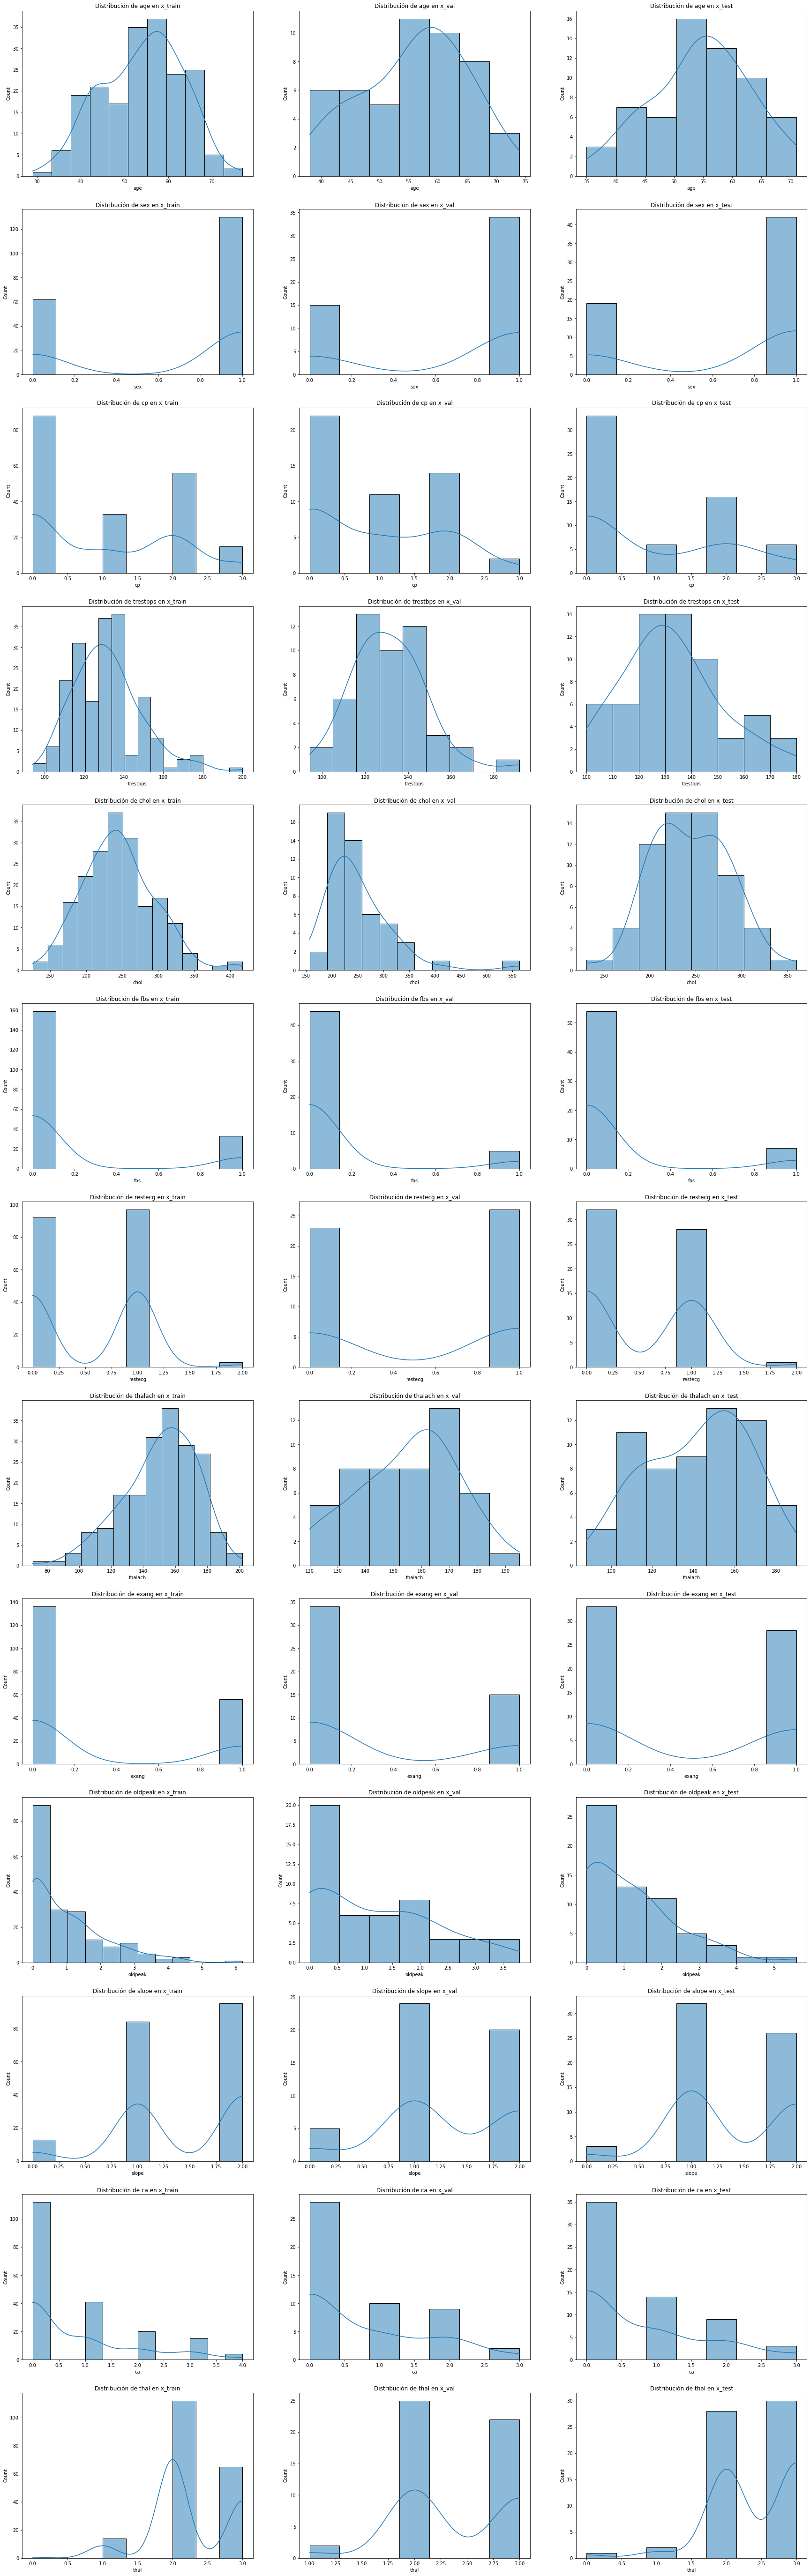

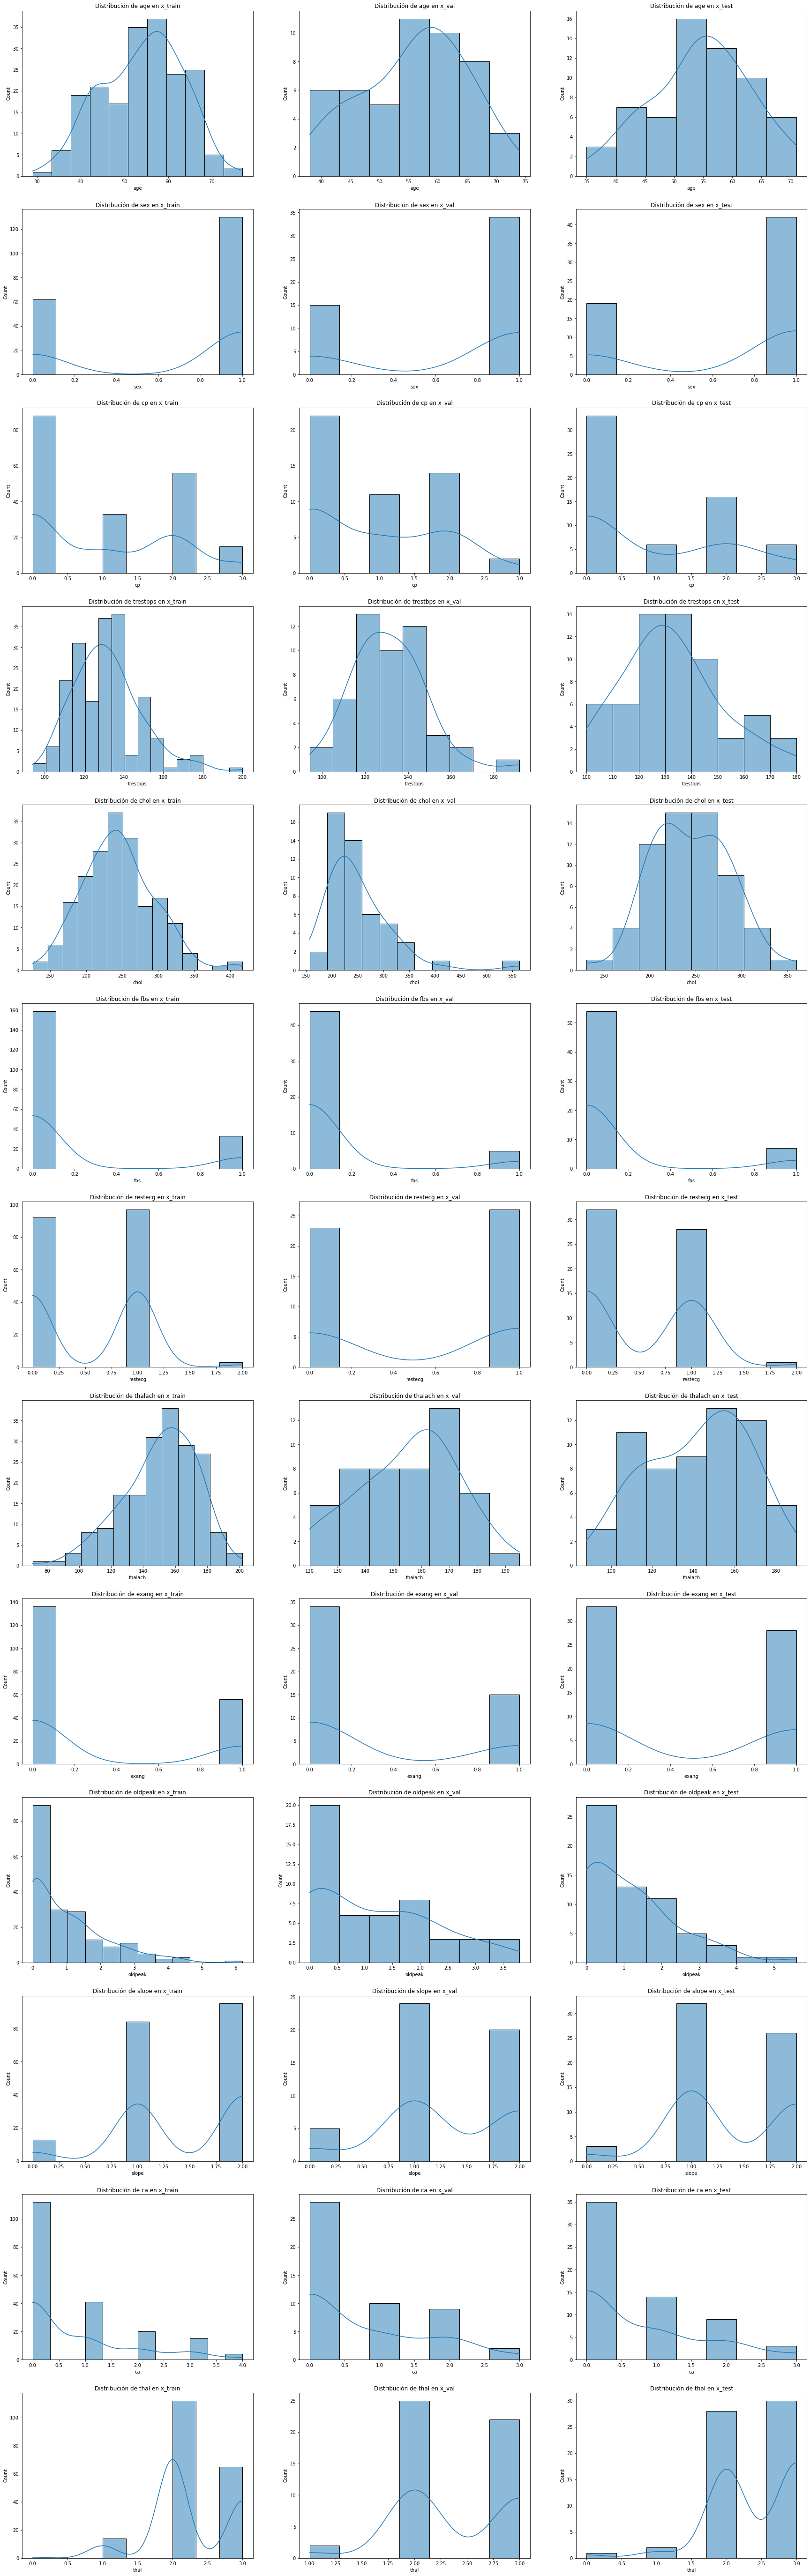

In [25]:
# Graficar la distribución de los conjuntos de datos
fig, ax = graph_var(x_train=x_train, x_val=x_val, x_test=x_test, vars=x_data.columns)
fig

Tras observar las distribuciones en los tres subconjuntos para cada una de las caracteristicas de los datos podemos concluir que las tres particiones mantienen la misma distribución. No obstante, existen algunas discrepancias que podemos observar en el conjunto de validación con respecto a las variables: thal, oldpeak y restecg. La dsitribución de estas tres variables parece diferir con respecto a los conjuntos de entrenamiento y test. Con respecto al conjunto de test, la única discrepancia observable reside en la distribución del colesterol (chol)

## Construcción del modelo

El modelo que vamos a emplear nos va ayudar a clasificar si una persona presenta un riesgo alto de sufir un ataque cardiaco o no. El objetivo de negocio de este modelo consiste en ayudar a priorizar automaticamente si un paciente requiere realizarse examenes exahustivos para ayudar a detectar oportunamente si posee riesgos de padecer un ataque cardiaco, lo anterior, bajo el marco de los programas de promoción y prevención.

Para ello, vamos a considerar los siguientes modelos de clasificación: 
1. Máquina de soporte vectorial (SVM)
2. XGBoost
3. Perceptrón multicapa (MLP)
4. Random Forest. 

Las métricas que vamos a emplear son exactitud, precisión, f-score y entropía cruzada. Para seleccionar el mejor modelo nos vamos a enfocar en el que mayor f-score posea y menor entropía cruzada.

**TODO: Por cada modelo: Implementarlo y mostrar las métricas enunciadas**

A continuación, vamos a definir una función auxiliar que nos ayude a calcular rápidamente la métricas

In [26]:
def metrics(y_true: np.array, y_pred: np.array):
  cross_ent = log_loss(y_true=y_true, y_pred=y_pred)
  acc = accuracy_score(y_true=y_true, y_pred=y_pred)
  recall = recall_score(y_true=y_true, y_pred=y_pred)
  prec = precision_score(y_true=y_true, y_pred=y_pred)
  f1_s = f1_score(y_true=y_true, y_pred=y_pred)

  print(f"""
    Entropía cruzada: {cross_ent:.2f}
    Exactitud: {acc:.2f}
    Precisión: {prec:.2f}
    Recall: {recall:.2f}
    F1 Score: {f1_s:.2f}
  """)

### Máquina de soporte vectorial

**TODO: Elaborarlo**

### XGBoost

A continuación vamos a implementar el modelo utilizando el algoritmo: *Extreme Gradient Boosting (XGBoost)*

In [27]:
# Instanciar el clasificador
xgb_reg = xgb.XGBClassifier(    
    tree_method="hist",
    eval_metric="logloss",
)

In [28]:
# Entrenar el clasificador
xgb_reg.fit(X=x_train, y=y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [29]:
# Calcular predicción: vamos a emplear el conjunto de validación
xgb_y_pred = xgb_reg.predict(x_val)

In [30]:
# Calcular métricas
metrics(y_true=y_val, y_pred=xgb_y_pred)


    Entropía cruzada: 6.34
    Exactitud: 0.82
    Precisión: 0.81
    Recall: 0.85
    F1 Score: 0.83
  


### Perceptrón multicapa (MLP)

Para la definición del modelo de perceptrón multicapa vamos a emplear la libreria de alto nivel Keras soportada por el motor de Tensorflow

In [31]:
# Definición del modelo
mlp_model = keras.models.Sequential([
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid")
])

In [32]:
# Compilación y entrenamiento del modelo
mlp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[      
      keras.metrics.Precision(),
      keras.metrics.Recall(),
    ]
)

mlp_model.fit(
    x=x_train,
    y=y_train,
    epochs=10,    
)

Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 26.6797 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 0s 1ms/step - loss: 5.0402 - precision: 0.5859 - recall: 0.6757    
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.3027 - precision: 0.5781 - recall: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 1ms/step - loss: 2.3641 - precision: 0.6154 - recall: 0.6486
Epoch 5/10
6/6 [==============================] - 0s 1ms/step - loss: 2.3155 - precision: 0.7692 - recall: 0.1802    
Epoch 6/10
6/6 [==============================] - 0s 1ms/step - loss: 1.6971 - precision: 0.6180 - recall: 0.9910
Epoch 7/10
6/6 [==============================] - 0s 1ms/step - loss: 1.2413 - precision: 0.6429 - recall: 0.5676
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.9545 - precision: 0.6696 - recall: 0.6757
Epoch 9/10
6/6 [==============================] - 0s 1ms/step - loss: 0

In [33]:
# Calcular predicción: vamos a emplear el conjunto de validación
mlp_y_pred = (mlp_model.predict(x_val) > 0.5).astype("int32")

In [34]:
# Calcular métricas
metrics(y_true=y_val, y_pred=mlp_y_pred)


    Entropía cruzada: 14.10
    Exactitud: 0.59
    Precisión: 0.57
    Recall: 0.88
    F1 Score: 0.70
  


### Random Forest

In [87]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=15000, max_depth=22, random_state=24, criterion='entropy'))

In [88]:
clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=22,
                                                     n_estimators=15000,
                                                     n_jobs=-1,
                                                     random_state=24))

In [89]:
y_pred_clf_1 = clf.predict_proba(x_test)
y_pred_clf_1.shape

(61, 2)

In [90]:
roc_auc_score(y_test_d, y_pred_clf_1[:,1], average='macro')

0.8899782135076253

### Generación de variables dummies a partir de los datos categoricos

In [86]:
df_cat = df
df_cat[['sex','cp','fbs','restecg','exang','slope','ca','thal','target']] = df_cat[['sex','cp','fbs','restecg','exang','slope','ca','thal','target']].astype('category')

# Selección de las variables de entrenamiento
y_dumm = df_cat["target"]
x_dumm = df_cat.drop(columns="target")

x_dumm = pd.get_dummies(x_dumm)

# Separar el conjunto de test: 20%
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(x_dumm, y_dumm, test_size=0.2, random_state=5)

# Separar el conjunto de validación: 20%
x_train_d_val, x_test_d_val, y_train_d_val, y_test_d_val = train_test_split(x_train_d, y_train_d, test_size=0.2, random_state=6)
x_train_d_val.head(4)

age  trestbps  chol  thalach  oldpeak  sex_0  sex_1  cp_0  cp_1  cp_2  \
31    65       120   177      140      0.4      0      1     1     0     0   
204   62       160   164      145      6.2      1      0     1     0     0   
0     63       145   233      150      2.3      0      1     0     0     0   
214   56       125   249      144      1.2      0      1     1     0     0   

     ...  slope_2  ca_0  ca_1  ca_2  ca_3  ca_4  thal_0  thal_1  thal_2  \
31   ...        1     1     0     0     0     0       0       0       0   
204  ...        0     0     0     0     1     0       0       0       0   
0    ...        0     1     0     0     0     0       0       1       0   
214  ...        0     0     1     0     0     0       0       0       1   

     thal_3  
31        1  
204       1  
0         0  
214       0  

[4 rows x 30 columns]

#### Comparación del modelo con variables dummies

In [37]:
# Definición del modelo
mlp_model_d = keras.models.Sequential([
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid")
])

# Compilación y entrenamiento del modelo
mlp_model_d.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[      
      keras.metrics.Precision(),
      keras.metrics.Recall(),
    ]
)

mlp_model_d.fit(
    x=x_train_d,
    y=y_train_d,
    epochs=10,    
)

Epoch 1/10
6/6 [==============================] - 0s 1ms/step - loss: 2.0759 - precision_2: 0.6602 - recall_2: 0.6126
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 1.4129 - precision_2: 0.6615 - recall_2: 0.7748
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 1.0585 - precision_2: 0.7579 - recall_2: 0.6486
Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.9180 - precision_2: 0.6899 - recall_2: 0.8018
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.8624 - precision_2: 0.7477 - recall_2: 0.7207
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.8269 - precision_2: 0.7063 - recall_2: 0.8018
Epoch 7/10
6/6 [==============================] - 0s 1ms/step - loss: 0.7822 - precision_2: 0.7304 - recall_2: 0.7568
Epoch 8/10
6/6 [==============================] - 0s 1ms/step - loss: 0.6877 - precision_2: 0.7451 - recall_2: 0.6847
Epoch 9/10
6/6 [==============================] - 0s 1ms

In [39]:
# Calcular predicción: vamos a emplear el conjunto de validación
mlp_y_pred_d = (mlp_model_d.predict(x_val_d) > 0.5).astype("int32")

# Calcular métricas
metrics(y_true=y_val_d, y_pred=mlp_y_pred_d)


    Entropía cruzada: 11.98
    Exactitud: 0.65
    Precisión: 0.74
    Recall: 0.54
    F1 Score: 0.62
  


### Modelos de clasificación con variables dummies

##### Multi-layer Perceptron classifier

In [41]:
nn=MLPClassifier(hidden_layer_sizes=(256,256,4),activation="tanh",max_iter=500000,warm_start=True)

In [42]:
t_score=nn.fit(x_train_d, y_train_d)

In [43]:
test_score=t_score.score(x_train_d, y_train_d)
test_score

1.0

In [54]:
y_pred=nn.predict(x_test_d)
roc_auc_score(y_test_d, y_pred, average='macro')

0.8191721132897604

**Predicción del modelo con los datos del validación**

In [55]:
y_pred_val=nn.predict(x_test_d_val)
roc_auc_score(y_test_d_val, y_pred_val, average='macro')

0.7516722408026756

### Random Forest

In [74]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=15000, max_depth=22, random_state=24, criterion='entropy'))

In [75]:
clf.fit(x_train_d, y_train_d)

OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=22,
                                                     n_estimators=15000,
                                                     n_jobs=-1,
                                                     random_state=24))

In [79]:
y_pred_clf = clf.predict_proba(x_test_d)
y_pred_clf.shape

(61, 2)

In [85]:
roc_auc_score(y_test_d, y_pred_clf[:,1], average='macro')

0.8954248366013071

## Despliegue del modelo

Para realizar el despliegue del modelo vamos a emplear una aproximación mediante contenedores. Para la interfaz de usuario, vamos a emplear una página web de una vista desarrollada con el framework: **TODO: Completar** en la cual podremos ingresar cada uno de los valores de las variables predictoras.

Si desea ingresar a la interfaz web, por favor no olvide configurar el enrutamiento por proxy a la universidad en su navegador. Para ello, configure los siguientes valores.

- Tipo de proxy: http.
- IP / URL: connect2.virtual.uniandes.edu.co
- Puerto: 443

Posteriormente, haga clic en el siguiente enlace:

[Interfaz Web](http://172.24.99.227:3000)

## Conclusiones

1. Al generar variables dummies a partir de las variables categoricas los modelos de clasificación quedan con un score de predicción mas alto

2. El modelo de random forest es el que nos ha generado un score mas alto, siendo para el ejercicio uno de los modelos con poder de predicción mas alto